In [1]:
import os
import time
import requests
import sys


def retrieve_html():
    for year in range(2013,2025):
        for month in range(1,13):
            if(month<10):
                url='https://en.tutiempo.net/climate/0{}-{}/ws-417800.html'.format(month
                                                                          ,year)
            else:
                url='https://en.tutiempo.net/climate/{}-{}/ws-417800.html'.format(month
                                                                          ,year)
            texts=requests.get(url)
            text_utf=texts.text.encode('utf-8')  # Fixed encoding string
            
            # Create the correct directory path
            if not os.path.exists("Downloads/Data/Html_Data/{}".format(year)):
                os.makedirs("Downloads/Data/Html_Data/{}".format(year))
            # Write to the correct path that matches the directory we created
            with open("Downloads/Data/Html_Data/{}/{}.html".format(year,month),"wb") as output:
                output.write(text_utf)
            
        sys.stdout.flush()
        
if __name__=="__main__":
    start_time=time.time()
    retrieve_html()
    stop_time=time.time()
    print("Time taken {}".format(stop_time-start_time))

Time taken 100.5595190525055


In [4]:
import os
import pandas as pd
from bs4 import BeautifulSoup


def extract_data(year,month):
    final_data = []

    for month in range(1, 13):
        file_path = f"Downloads/Data/Html_Data/{year}/{month}.html"
        if not os.path.exists(file_path):
            continue

        with open(file_path, 'rb') as file:
            soup = BeautifulSoup(file, 'lxml')

        table = soup.find("table", attrs={"class": "medias mensuales numspan"})

        if table is None:
            continue

        rows = table.find_all("tr")[1:]  # Skip header row

        for row in rows:
            cols = row.find_all("td")
            if len(cols) >= 10:
                date = cols[0].text.strip()
                pm25 = cols[9].text.strip()
                final_data.append([f"{year}-{month:02d}-{date}", pm25])

    return pd.DataFrame(final_data, columns=["Date", "PM2.5"])


def generate_csv():
    # Create the directory if it doesn't exist
    os.makedirs("Data/AQI", exist_ok=True)  # This line creates the directory if it doesn't exist
    
    for year in range(2013, 2025):
        df = extract_data(year,range(1,13))
        if not df.empty:
            df.to_csv(f"Data/AQI/aqi{year}.csv", index=False)
            print(f"Saved: aqi{year}.csv")
        else:
            print(f"No data found for {year}")

if __name__ == "__main__":
    generate_csv()

Saved: aqi2013.csv
Saved: aqi2014.csv
Saved: aqi2015.csv
Saved: aqi2016.csv
Saved: aqi2017.csv
Saved: aqi2018.csv
Saved: aqi2019.csv
Saved: aqi2020.csv
Saved: aqi2021.csv
Saved: aqi2022.csv
Saved: aqi2023.csv
Saved: aqi2024.csv


In [5]:
df=pd.read_csv('Downloads/Data/AQI/aqi2020.csv')
df.describe()

,PM2.5
count,378.000000
mean,20.674074
std,7.301529
min,7.600000
25%,14.800000
50%,18.300000
75%,25.900000
max,64.400000


In [6]:
df.head()

,Date,PM2.5
0,2020-01-1,33.5
1,2020-01-2,25.9
2,2020-01-3,7.6
3,2020-01-4,18.3
4,2020-01-5,14.8


In [8]:
import os
import pandas as pd
from bs4 import BeautifulSoup

def calculate_pm25_aqi(pm25):
    try:
        pm25 = float(pm25)
    except:
        return None, "Invalid"

    breakpoints = [
        (0.0, 12.0, 0, 50, "Good"),
        (12.1, 35.4, 51, 100, "Moderate"),
        (35.5, 55.4, 101, 150, "Unhealthy for Sensitive Groups"),
        (55.5, 150.4, 151, 200, "Unhealthy"),
        (150.5, 250.4, 201, 300, "Very Unhealthy"),
        (250.5, 500.4, 301, 500, "Hazardous"),
    ]

    for (c_low, c_high, aqi_low, aqi_high, category) in breakpoints:
        if c_low <= pm25 <= c_high:
            aqi = ((aqi_high - aqi_low) / (c_high - c_low)) * (pm25 - c_low) + aqi_low
            return round(aqi), category

    return None, "Out of Range"


def extract_data(year,month):
    final_data = []

    for month in range(1, 13):
        file_path = f"Downloads/Data/Html_Data/{year}/{month}.html"
        if not os.path.exists(file_path):
            continue

        with open(file_path, 'rb') as file:
            soup = BeautifulSoup(file, 'lxml')

        table = soup.find("table", attrs={"class": "medias mensuales numspan"})

        if table is None:
            continue

        rows = table.find_all("tr")[1:]  # Skip header row

        for row in rows:
            cols = row.find_all("td")
            if len(cols) >= 10:
                date = cols[0].text.strip()
                pm25 = cols[9].text.strip()
                final_data.append([f"{year}-{month:02d}-{date}", pm25])
                try:
                    pm25_val = float(pm25)
                    aqi, category = calculate_pm25_aqi(pm25_val)
                except:
                    pm25_val, aqi, category = None, None, "Invalid"

                final_data.append([date, pm25_val, aqi, category])

    return pd.DataFrame(final_data, columns=["Date", "PM2.5","AQI","AQI-Bucket"])


def generate_csv_with_aqi(start_year=2013, end_year=2025):
    for year in range(start_year, end_year + 1):
        df = extract_data(year,range(1,13))

        # Make output directory
        os.makedirs("Data/Processed", exist_ok=True)
        output_path = f"Data/Processed/aqi_{year}.csv"
        df.to_csv(output_path, index=False)
        print(f"[✓] Saved: {output_path}")
        
# === Main ===
if __name__ == "__main__":
    generate_csv_with_aqi()

[✓] Saved: Data/Processed/aqi_2013.csv
[✓] Saved: Data/Processed/aqi_2014.csv
[✓] Saved: Data/Processed/aqi_2015.csv
[✓] Saved: Data/Processed/aqi_2016.csv
[✓] Saved: Data/Processed/aqi_2017.csv
[✓] Saved: Data/Processed/aqi_2018.csv
[✓] Saved: Data/Processed/aqi_2019.csv
[✓] Saved: Data/Processed/aqi_2020.csv
[✓] Saved: Data/Processed/aqi_2021.csv
[✓] Saved: Data/Processed/aqi_2022.csv
[✓] Saved: Data/Processed/aqi_2023.csv
[✓] Saved: Data/Processed/aqi_2024.csv
[✓] Saved: Data/Processed/aqi_2025.csv


In [9]:
df=pd.read_csv('Data/Processed/aqi_2013.csv')
df.head()

,Date,PM2.5,AQI,AQI-Bucket
0,2013-01-1,18.3,NaN,NaN
1,1,18.3,64.0,Moderate
2,2013-01-2,27.8,NaN,NaN
3,2,27.8,84.0,Moderate
4,2013-01-3,20.6,NaN,NaN


In [10]:
df.describe()

,AQI
count,374.000000
mean,90.280749
std,19.889340
min,57.000000
25%,76.000000
50%,87.000000
75%,100.000000
max,163.000000


In [11]:
df.describe()

,AQI
count,374.000000
mean,90.280749
std,19.889340
min,57.000000
25%,76.000000
50%,87.000000
75%,100.000000
max,163.000000


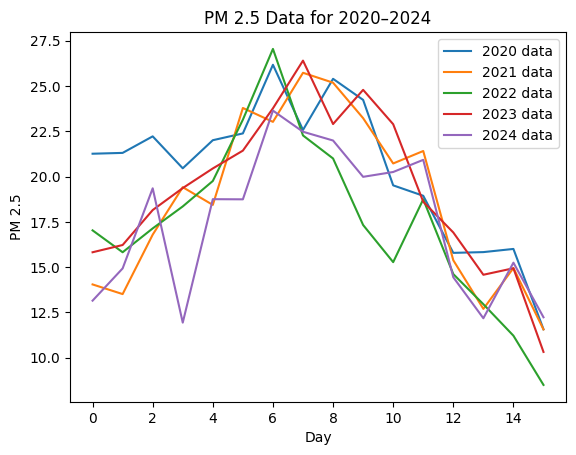

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


def avg_data_2020():
    temp_i = 0
    average = []
    for rows in pd.read_csv('Data/AQI/aqi2020.csv', chunksize=24):
        add_var = 0
        avg = 0.0
        data = []
        df = pd.DataFrame(data=rows)
        for index, row in df.iterrows():
            data.append(row['PM2.5'])
        for i in data:
            if isinstance(i, (float, int)):
                add_var += i
            elif isinstance(i, str):
                if i not in ['NoData', 'PwrFail', '---', 'InVld', '-']:
                    temp = float(i)
                    add_var += temp
        avg = add_var / 24
        temp_i += 1
        average.append(avg)
    return average


def avg_data_2021():
    temp_i = 0
    average = []
    for rows in pd.read_csv('Data/AQI/aqi2021.csv', chunksize=24):
        add_var = 0
        avg = 0.0
        data = []
        df = pd.DataFrame(data=rows)
        for index, row in df.iterrows():
            data.append(row['PM2.5'])
        for i in data:
            if isinstance(i, (float, int)):
                add_var += i
            elif isinstance(i, str):
                if i not in ['NoData', 'PwrFail', '---', 'InVld', '-']:
                    temp = float(i)
                    add_var += temp
        avg = add_var / 24
        temp_i += 1
        average.append(avg)
    return average


def avg_data_2022():
    temp_i = 0
    average = []
    for rows in pd.read_csv('Data/AQI/aqi2022.csv', chunksize=24):
        add_var = 0
        avg = 0.0
        data = []
        df = pd.DataFrame(data=rows)
        for index, row in df.iterrows():
            data.append(row['PM2.5'])
        for i in data:
            if isinstance(i, (float, int)):
                add_var += i
            elif isinstance(i, str):
                if i not in ['NoData', 'PwrFail', '---', 'InVld', '-']:
                    temp = float(i)
                    add_var += temp
        avg = add_var / 24
        temp_i += 1
        average.append(avg)
    return average


def avg_data_2023():
    temp_i = 0
    average = []
    for rows in pd.read_csv('Data/AQI/aqi2023.csv', chunksize=24):
        add_var = 0
        avg = 0.0
        data = []
        df = pd.DataFrame(data=rows)
        for index, row in df.iterrows():
            data.append(row['PM2.5'])
        for i in data:
            if isinstance(i, (float, int)):
                add_var += i
            elif isinstance(i, str):
                if i not in ['NoData', 'PwrFail', '---', 'InVld', '-']:
                    temp = float(i)
                    add_var += temp
        avg = add_var / 24
        temp_i += 1
        average.append(avg)
    return average


def avg_data_2024():
    temp_i = 0
    average = []
    for rows in pd.read_csv('Data/AQI/aqi2024.csv', chunksize=24):
        add_var = 0
        avg = 0.0
        data = []
        df = pd.DataFrame(data=rows)
        for index, row in df.iterrows():
            data.append(row['PM2.5'])
        for i in data:
            if isinstance(i, (float, int)):
                add_var += i
            elif isinstance(i, str):
                if i not in ['NoData', 'PwrFail', '---', 'InVld', '-']:
                    temp = float(i)
                    add_var += temp
        avg = add_var / 24
        temp_i += 1
        average.append(avg)
    return average


if __name__ == "__main__":
    lst2020 = avg_data_2020()
    lst2021 = avg_data_2021()
    lst2022 = avg_data_2022()
    lst2023 = avg_data_2023()
    lst2024 = avg_data_2024()

    plt.plot(range(len(lst2020)), lst2020, label="2020 data")
    plt.plot(range(len(lst2021)), lst2021, label="2021 data")
    plt.plot(range(len(lst2022)), lst2022, label="2022 data")
    plt.plot(range(len(lst2023)), lst2023, label="2023 data")
    plt.plot(range(len(lst2024)), lst2024, label="2024 data")

    plt.xlabel('Day')
    plt.ylabel('PM 2.5')
    plt.legend(loc='upper right')
    plt.title("PM 2.5 Data for 2020–2024")
    plt.show()
